In [1]:
import pandas as pd
import seaborn as sns
import numpy as np

from utils import shuffle, train_test_split, min_max_normalize, mean_absolute_error, mean_squared_error, root_mean_squared_error
from neighbors import KNNRegressor

In [2]:
fish = pd.read_csv('./data/Fish.csv')
fish.head()

,Species,Weight,Length1,Length2,Length3,Height,Width
0,Bream,242.0,23.2,25.4,30.0,11.5200,4.0200
1,Bream,290.0,24.0,26.3,31.2,12.4800,4.3056
2,Bream,340.0,23.9,26.5,31.1,12.3778,4.6961
3,Bream,363.0,26.3,29.0,33.5,12.7300,4.4555
4,Bream,430.0,26.5,29.0,34.0,12.4440,5.1340


In [3]:
fish.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159 entries, 0 to 158
Data columns (total 7 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Species  159 non-null    object 
 1   Weight   159 non-null    float64
 2   Length1  159 non-null    float64
 3   Length2  159 non-null    float64
 4   Length3  159 non-null    float64
 5   Height   159 non-null    float64
 6   Width    159 non-null    float64
dtypes: float64(6), object(1)
memory usage: 8.8+ KB


In [4]:
fish.isna().sum()

Species    0
Weight     0
Length1    0
Length2    0
Length3    0
Height     0
Width      0
dtype: int64

In [5]:
fish['Species'].value_counts()

Perch        56
Bream        35
Roach        20
Pike         17
Smelt        14
Parkki       11
Whitefish     6
Name: Species, dtype: int64

In [6]:
fish = pd.concat([fish, pd.get_dummies(fish['Species'])], axis=1)
fish.pop('Species')
;

''

In [7]:
fish.head()

,Weight,Length1,Length2,Length3,Height,Width,Bream,Parkki,Perch,Pike,Roach,Smelt,Whitefish
0,242.0,23.2,25.4,30.0,11.5200,4.0200,1,0,0,0,0,0,0
1,290.0,24.0,26.3,31.2,12.4800,4.3056,1,0,0,0,0,0,0
2,340.0,23.9,26.5,31.1,12.3778,4.6961,1,0,0,0,0,0,0
3,363.0,26.3,29.0,33.5,12.7300,4.4555,1,0,0,0,0,0,0
4,430.0,26.5,29.0,34.0,12.4440,5.1340,1,0,0,0,0,0,0


In [8]:
train, test = train_test_split(fish, train_size=0.7)

x_train = train.drop('Weight', axis=1)
x_test = test.drop('Weight', axis=1)

y_train = train['Weight']
y_test = test['Weight']

x_train, minmax = min_max_normalize(x_train)
x_test, _ = min_max_normalize(x_test)

x_test =x_test.fillna(0)
x_test.describe()

,Length1,Length2,Length3,Height,Width,Bream,Parkki,Perch,Pike,Roach,Smelt,Whitefish
count,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000
mean,0.337295,0.347294,0.359242,0.429153,0.500722,0.229167,0.062500,0.354167,0.083333,0.125000,0.104167,0.041667
std,0.216365,0.216421,0.225387,0.284059,0.266971,0.424744,0.244623,0.483321,0.279310,0.334219,0.308709,0.201941
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.189038,0.204876,0.202849,0.238613,0.338653,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.342282,0.351660,0.337917,0.333501,0.475291,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.478747,0.486515,0.525049,0.626095,0.713218,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [9]:
def show_error(y_pred):
    print('mae:', mean_absolute_error(y_pred, y_test))
    print('mse:', mean_squared_error(y_pred, y_test))
    print('rmse:', root_mean_squared_error(y_pred, y_test))

    display(pd.DataFrame([y_pred, y_test, y_pred - y_test], index=['y_pred', 'y_test', 'error']).T)   


In [10]:
knn = KNNRegressor(k=3, mode='mean')
knn.fit(x_train, y_train)

y_pred = knn.predict(x_test)
show_error(y_pred)

mae: 38.18541666666667
mse: 3344.3141435185184
rmse: 57.83004533560836


,y_pred,y_test,error
0,63.833333,70.0,-6.166667
1,956.666667,975.0,-18.333333
2,118.333333,110.0,8.333333
3,286.666667,320.0,-33.333333
4,116.666667,130.0,-13.333333
5,91.666667,120.0,-28.333333
6,216.666667,218.0,-1.333333
7,105.666667,145.0,-39.333333
8,116.666667,120.0,-3.333333
9,214.333333,300.0,-85.666667


In [11]:
knn = KNNRegressor(k=3, mode='weight')
knn.fit(x_train, y_train)

y_pred = knn.predict(x_test)
show_error(y_pred)

mae: 33.067331617704646
mse: 2300.293999782165
rmse: 47.96138029479724


,y_pred,y_test,error
0,58.498252,70.0,-11.501748
1,955.581806,975.0,-19.418194
2,118.598387,110.0,8.598387
3,291.005432,320.0,-28.994568
4,116.718771,130.0,-13.281229
5,91.781963,120.0,-28.218037
6,203.026823,218.0,-14.973177
7,107.129403,145.0,-37.870597
8,116.310927,120.0,-3.689073
9,245.023220,300.0,-54.976780


In [12]:
%%time
knn = KNNRegressor(k=1, mode='mean')
knn.fit(x_train, y_train)

hist = []
for k in range(1, 20, 3):
    knn.k = k
    y_pred = knn.predict(y_test)
    rmse =mean_absolute_error(y_pred, y_test)
    hist.append([k, rmse])

CPU times: user 9.44 ms, sys: 586 µs, total: 10 ms
Wall time: 9.33 ms


besk k:19	594.17


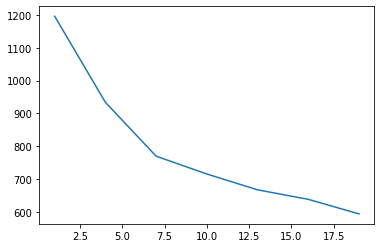

In [13]:
hist = np.array(hist)
sns.lineplot(x = hist[:, 0], y= hist[:, 1])
best =  hist[np.argmin(hist[:, 1])]
print('besk k:%d\t%.2f'%(int(best[0]), best[1]))

In [14]:
%%time
knn = KNNRegressor(k=1, mode='weight')
knn.fit(x_train, y_train)

hist = []
for k in range(1, 20, 3):
    knn.k = k
    y_pred = knn.predict(y_test)
    rmse =  mean_absolute_error(y_pred, y_test)
    hist.append([k, rmse])

CPU times: user 7.99 ms, sys: 4.01 ms, total: 12 ms
Wall time: 11.2 ms


besk k:19	594.24


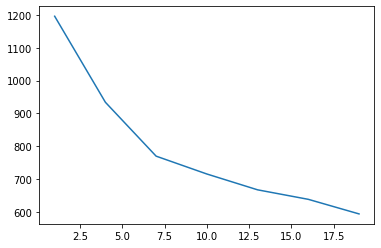

In [15]:
hist = np.array(hist)
sns.lineplot(x = hist[:, 0], y= hist[:, 1])

best =  hist[np.argmin(hist[:, 1])]
print('besk k:%d\t%.2f'%(int(best[0]), best[1]))